## How to predict stream using a trained model

#Here we show how to predict continous waveform using a trained u-net model (unet.ckpt-590000)

# load modules

In [1]:
from __future__ import print_function

import os
from obspy import UTCDateTime
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from data_io import load_stream
import numpy as np
import tensorflow as tf
import time
import unet

/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs/eirs/lib/python3.6/site-packages

# Subroutine 

In [2]:
def preprocess_stream(stream):
    stream = stream.detrend('constant')
    ##add by mingzhao,2017/12/2
    stream =stream.filter('bandpass', freqmin=0.5, freqmax=20)
    ##########
    return stream

def fetch_window_data(stream,j):
    """fetch data from a stream window and dump in np array"""
    data = np.empty((3001, j))
    for i in range(j):
        data[:, i] = stream[i].data.astype(np.float32)
    data = np.expand_dims(data, 0)
    return data

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

# input parameters

In [3]:
n_events = 0
time_start = time.time()
stream_path =""
checkpoint_path ="unet.ckpt-590000"
batch_size=1 
output_dir="output/predict_from_stream"
window_size=30
window_step=31
image_size=3001
stream_file="./PWU_20080720223030_30s.mseed"

# the continuous waveform

In [4]:
stream = load_stream(stream_file)
stream = stream.normalize()

print (" + Preprocess stream {}".format(stream))
stream = preprocess_stream(stream)
print (" -- Stream is ready, starting detection")
# stream.plot()

 + Preprocess stream 3 Trace(s) in Stream:
XX.PWU..BHE | 2008-07-20T22:30:30.000000Z - 2008-07-20T22:31:00.000000Z | 100.0 Hz, 3001 samples
XX.PWU..BHN | 2008-07-20T22:30:30.000000Z - 2008-07-20T22:31:00.000000Z | 100.0 Hz, 3001 samples
XX.PWU..BHZ | 2008-07-20T22:30:30.000000Z - 2008-07-20T22:31:00.000000Z | 100.0 Hz, 3001 samples
 -- Stream is ready, starting detection


# the predict process using unet (with tensorflow)

input_shape,output_shape Tensor("upsample6/Shape:0", shape=(3,), dtype=int32) Tensor("upsample6/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 128 Tensor("upsample6/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample6/weights:0' shape=(8, 128, 128) dtype=float32_ref>
input_shape,output_shape Tensor("upsample7/Shape:0", shape=(3,), dtype=int32) Tensor("upsample7/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 128 Tensor("upsample7/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample7/weights:0' shape=(8, 128, 128) dtype=float32_ref>
input_shape,output_shape Tensor("upsample8/Shape:0", shape=(3,), dtype=int32) Tensor("upsample8/stack:0", shape=(3,), dtype=int32)
num_filters_in, output_shape,weights 64 Tensor("upsample8/stack:0", shape=(3,), dtype=int32) <tf.Variable 'upsample8/weights:0' shape=(8, 64, 64) dtype=float32_ref>
input_shape,output_shape Tensor("upsample9/Shape:0", shape=(3,), dtype=int32) Tensor("upsample9/stack:0", 

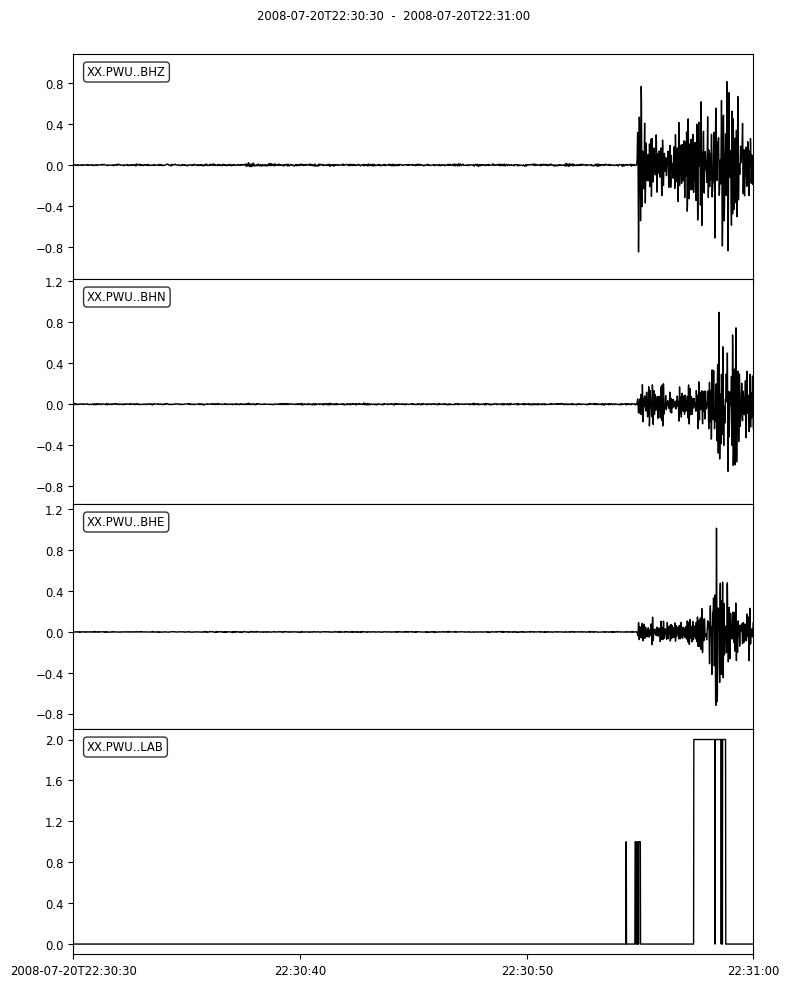

In [5]:
samples = {
        'data': tf.placeholder(tf.float32,
                                   shape=(batch_size, image_size, 3),
                                   name='input_data')}
with tf.Session() as sess:
    # 初始化model
    logits = unet.build_30s(samples['data'], 3, False)

    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    # writer = tf.summary.FileWriter("logs/", sess.graph)
    sess.run(init_op)
    saver = tf.train.Saver()

    if not tf.gfile.Exists(checkpoint_path + '.meta'):
        raise ValueError("Can't find checkpoint file")
    else:
        print('[INFO    ]\tFound checkpoint file, restoring model.')
        saver.restore(sess, checkpoint_path)
    coord = tf.train.Coordinator()

    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    # 处理数据
    # win_gen = stream.slide(window_length=window_size, step=30, include_partial_windows=True)
    predicted_images = unet.predict(logits, batch_size, image_size)
    to_fetch = [predicted_images, samples['data']]

    feed_dict = {samples['data']: fetch_window_data(stream.copy().normalize(), 3)}

    predicted_images_value, images_value = sess.run(to_fetch, feed_dict)

    clusters_p = np.where(predicted_images_value[0, :] == 1)
    p_boxes = group_consecutives(clusters_p[0])
    tp = []
    tpstamp = []

    if len(p_boxes) > 1:
        for ip in range(len(p_boxes)):
            # print (len(p_boxes),p_boxes,p_boxes[ip])
            tpmean = float(min(p_boxes[ip]) / 200.00 + max(p_boxes[ip]) / 200.00)
            tp.append(tpmean)
            tpstamp = UTCDateTime(stream[0].stats.starttime + tpmean).timestamp
            # print(UTCDateTime(tpstamp))

    win_filtered = stream.copy()
    lab = win_filtered[2].copy()
    lab.stats.channel = "LAB"
    # lab =win[0].copy()

    print("predicted_images_value", predicted_images_value.shape)
    lab.data[...] = predicted_images_value[0, :]
    win_filtered += lab
    # win_filtered[-2:].plot()
    win_filtered.plot()
    # Wait for threads to finish.
    coord.join(threads)
    print("pwave timestamp: ", tpstamp)
    print("pwave UTCtime: ", UTCDateTime(tpstamp))

In [6]:
# lists = np.arange(0,30,10)
# for i in lists:
#     win_gen = stream.slide(window_length=window_size, step=window_step,offset=i,
#                                                                              include_partial_windows=False)
#     for st in win_gen:
#         print(st)
# win_gen = stream.slide(window_length=window_size, step=30, include_partial_windows=True)
# for st in win_gen:
#     print(st)

In [7]:
# 生成前30s,3001个样本点数据
from obspy import read, UTCDateTime
import os
# st = read("PWU20080720223000.mseed")
# dt = st[0].stats.starttime
# stream_cut = st.slice(dt + 30, dt + 60)
# print(stream_cut)
#
# output_mseed_dir = "/Users/cui/Desktop"
# output_label = "{}_{}_30s.mseed".format(stream_cut[0].stats.station,
#                                     UTCDateTime(stream_cut[0].stats.starttime).strftime("%Y%m%d%H%M%S"))
# output_mseed = os.path.join(output_mseed_dir, output_label)
# stream_cut.write(output_mseed, format="MSEED")